# Load Dataset

In [1]:
import pandas as pd

In [2]:
df = pd.read_xml('./JASSS_DATA/jasss/jass_paper_final.xml')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     776 non-null    object
 1   Writer    776 non-null    object
 2   KeyWord   575 non-null    object
 3   Abstract  234 non-null    object
dtypes: object(4)
memory usage: 24.4+ KB


In [3]:
df.head()

,Title,Writer,KeyWord,Abstract
0,Agent-Based Modelling of Future Dairy and Plan...,"Matthew Gibson, Joana Portugal Pereira, Raphae...","Plant-Based Milk, Dairy Reduction, Sustainable...",A reduction in the production and consumption ...
1,ReMoTe-S. Residential Mobility of Tenants in S...,"Anna Pagani, Francesco Ballestrazzi, Emanuele ...","Household Mobility, Household Relocation, Hous...",Sustainable housing is a key priority for Swit...
2,Sharing Risk Under Heterogeneity: Exploring Pa...,Eva Vriens and Vincent Buskens,"Risk-Sharing, Risk Aversion, Solidarity, Uncer...",Motivated by the emergence of new Peer-to-Peer...
3,An Agent-Based Model of Motor Insurance Custom...,"Rei England, Iqbal Owadally and Douglas Wright","Insurance, Word-Of-Mouth, Agent-Based-Model, N...",Attracting and retaining loyal customers is a ...
4,Generation of Synthetic Populations in Social ...,"Kevin Chapuis, Patrick Taillandier and Alexis ...","Synthetic Population, Agent-Based Simulation M...",With the aim of building realistic model of so...


In [4]:
df = df[['Title', 'Writer', 'KeyWord', 'Abstract']]
df.fillna("",inplace=True)

In [5]:
df['Description'] = df['Abstract'] + ' ' + df['KeyWord'] + ' ' + df['Title']
df = df[['Title','Description']]
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 776 entries, 0 to 775
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        776 non-null    object
 1   Description  776 non-null    object
dtypes: object(2)
memory usage: 18.2+ KB


In [6]:
df.head()

,Title,Description
0,Agent-Based Modelling of Future Dairy and Plan...,A reduction in the production and consumption ...
1,ReMoTe-S. Residential Mobility of Tenants in S...,Sustainable housing is a key priority for Swit...
2,Sharing Risk Under Heterogeneity: Exploring Pa...,Motivated by the emergence of new Peer-to-Peer...
3,An Agent-Based Model of Motor Insurance Custom...,Attracting and retaining loyal customers is a ...
4,Generation of Synthetic Populations in Social ...,With the aim of building realistic model of so...


# Cluster Similar Papers

How to cluster text documents:
- Text pre-processing
- Feature Engineering
- Clustering Using KMeans
- Find Optimal Value for K
- Prepare Paper Clusters

## Text pre-processing

In [7]:
import nltk
import re
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [8]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['also','agent','agentbased model','well'])

In [9]:
def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = nltk.word_tokenize(doc)
    tokens_tags = nltk.pos_tag(tokens)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token, tag in tokens_tags:
        if tag in ['RBS','RBR', 'RB']:
            lemmatized_tokens.append(wordnet_lemmatizer.lemmatize(token, pos='r'))
        elif tag in ['JJ','JJS','JJR']:
            lemmatized_tokens.append(wordnet_lemmatizer.lemmatize(token, pos='a'))
        elif tag in ['VB','VBP','VBZ','VBD','VBN','VBG']:
            lemmatized_tokens.append(wordnet_lemmatizer.lemmatize(token, pos='v'))
        elif tag in ['NN','NNS','NNP','NNPS']:
            lemmatized_tokens.append(wordnet_lemmatizer.lemmatize(token, pos='n'))
        else:
            lemmatized_tokens.append(wordnet_lemmatizer.lemmatize(token))
    filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

In [10]:
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(df['Description'].values)

In [11]:
len(norm_corpus)

776

In [12]:
norm_corpus[0]

'reduction production consumption meat dairy across much world critical climate change mitigation alleviation ecological stress improved health update agentbased model abm historic uk milk consumption apply scenario dairy reduction adoption plantbased milk pbm 2050 update model comprise cognitive function perceive physical health environmental characteristic milk choice modify habit social influence use european social survey 2018 british social attitude 2008 survey data empirically inform model take backcasting approach calibrate parameter publish uk dairy reduction target 2030 2050 test different price relationship characterisation environmental concern may affect simulated milk consumption 2020 2050 scenario core target 20 less dairy 2030 35 2050 largely produce plausible consumption trajectory however current pricing dairy pbm simulate consumption mostly unable deliver desire core target improved markedly dairy price set organic level influence change environmental concern milk cho

In [13]:
df['Description'].values[0]

'A reduction in the production and consumption of meat and dairy across much of the world is critical for climate change mitigation, the alleviation of ecological stress, and improved health. We update an agent-based model (ABM) of historic UK milk consumption and apply it to scenarios of dairy reduction and adoption of plant-based milk (PBM) out to 2050. The updated model is comprised of a cognitive function, where agents perceive the physical, health and environmental characteristics of milk choice, which is modified by habit and social influence. We use European Social Survey 2018 and British Social Attitudes 2008 survey data to empirically inform the model. Taking a backcasting approach, we calibrate parameters against published UK dairy reduction targets (2030 and 2050), and test how different price relationships, and characterisations of environmental concern, may affect simulated milk consumption from 2020 to 2050. Scenarios for core targets (20% less dairy by 2030 and 35% by 20

## Token Vectorize

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
len(stop_words)

183

In [16]:
# Token Vectorize
cv = CountVectorizer(ngram_range=(1,2), min_df=80, max_df=0.9, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

/Users/arieskoo/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['agentbased', 'model'] not in stop_words.
  warnings.warn(


(776, 23)

## Extract TF-IDF Feature

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

In [18]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(cv_matrix)
tfidf_matrix = tfidf.toarray()

## TSNE Dimension Reduction for Plotting

In [19]:
from sklearn import manifold

In [20]:
tsne = manifold.TSNE(n_components=2, perplexity=20.0, learning_rate=200.0, n_iter=1000, init='pca', random_state=1)
tsne_tfidf_matrix = tsne.fit_transform(tfidf_matrix)

/Users/arieskoo/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [21]:
[row[0] for row in tsne_tfidf_matrix[0:3]]

[-3.2407339, 40.77883, 3.8148983]

## Cluster Papers using K-Means

In [22]:
from sklearn.cluster import KMeans

In [23]:
MIN_CLUSTERS = 15
MAX_CLUSTERS = 40

## Determine the number of clusters

### Method 1: Cross Validation + Silehouette Coefficient

In [24]:
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt

In [25]:
def cross_validation_k(data, num_clusters, folds=5):
    km = KMeans(n_clusters=num_clusters, max_iter=10000, n_init=50, random_state=10)
    kf = KFold(n_splits=folds)
    train_sil = 0
    test_sil = 0
    for train, test in kf.split(data):
        test_data = data[test,:]
        train_data = data[train,:]
        train_model = km.fit(train_data)
        train_labels = train_model.labels_
        test_labels = train_model.predict(test_data)
        
        test_silhouette = metrics.silhouette_score(test_data, test_labels, metric='euclidean')
        train_silhouette = metrics.silhouette_score(train_data, train_labels, metric='euclidean')
        
        train_sil += train_silhouette
        test_sil += test_silhouette

    train_mean_sil = train_sil/folds
    test_mean_sil = test_sil/folds
    print(f'Train mean silhouette: {train_mean_sil}')
    print(f'Testing mean silhouette: {test_mean_sil}')
    print()
    return train_mean_sil, test_mean_sil

In [26]:
mean_silhouette = [[], []]
x = []
for NUM_CLUSTERS in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    x.append(NUM_CLUSTERS)
    print(f'Cluster Number is: {NUM_CLUSTERS}')
    train_mean_sil, test_mean_sil = cross_validation_k(tsne_tfidf_matrix, NUM_CLUSTERS, 5)
    mean_silhouette[0].append(train_mean_sil)
    mean_silhouette[1].append(test_mean_sil)

Cluster Number is: 15
Train mean silhouette: 0.5065707623958587
Testing mean silhouette: 0.49105684757232665

Cluster Number is: 16
Train mean silhouette: 0.5137243092060089
Testing mean silhouette: 0.4936575055122375

Cluster Number is: 17
Train mean silhouette: 0.5136872172355652
Testing mean silhouette: 0.46861971020698545

Cluster Number is: 18
Train mean silhouette: 0.5125334978103637
Testing mean silhouette: 0.4715671598911285

Cluster Number is: 19
Train mean silhouette: 0.5170225262641907
Testing mean silhouette: 0.46748470067977904

Cluster Number is: 20
Train mean silhouette: 0.5115894734859466
Testing mean silhouette: 0.4742341756820679

Cluster Number is: 21
Train mean silhouette: 0.5128482520580292
Testing mean silhouette: 0.46951727867126464

Cluster Number is: 22
Train mean silhouette: 0.5070148050785065
Testing mean silhouette: 0.47509450912475587

Cluster Number is: 23
Train mean silhouette: 0.5091674506664277
Testing mean silhouette: 0.47752506732940675

Cluster Numbe

### Method 2: Elbow Curve Method

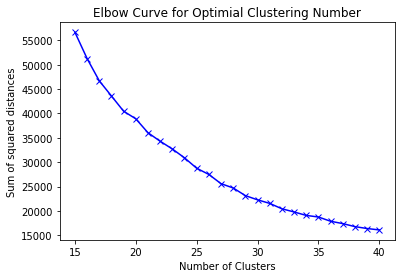

In [27]:
sum_of_squared_dis = []
for NUM_CLUSTERS in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    kmeans = KMeans(n_clusters=NUM_CLUSTERS)
    kmeans.fit(tsne_tfidf_matrix)
    sum_of_squared_dis.append(kmeans.inertia_)
plt.plot(range(MIN_CLUSTERS, MAX_CLUSTERS+1), sum_of_squared_dis, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Curve for Optimial Clustering Number')
# plt.show()
plt.savefig('elbow.png', dpi=150)

The best clustering number could be 5 from this graph.

### Silhouette analysis

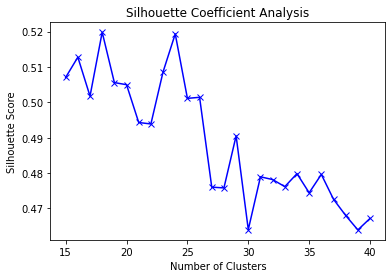

In [28]:
silhouette_avg = []
for NUM_CLUSTERS in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    kmeans = KMeans(n_clusters=NUM_CLUSTERS)
    kmeans.fit(tsne_tfidf_matrix)
    cluster_labels = kmeans.labels_
    
    silhouette_avg.append(metrics.silhouette_score(tsne_tfidf_matrix, cluster_labels))
    
plt.plot(range(MIN_CLUSTERS, MAX_CLUSTERS+1), silhouette_avg, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Coefficient Analysis')
# plt.show()
plt.savefig('elbowsil.png', dpi=150)

So combining elbow curve method with silhouette coefficient, we find elbow method is not that accurate and stable.

### Method 3: Rule of Thumb

In [29]:
NUM_CLUSTERS = round((len(norm_corpus)/2)**0.5)
NUM_CLUSTERS

20

## Visualize

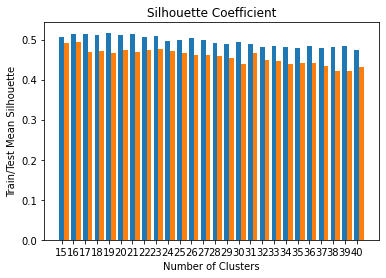

In [30]:
width = 0.4
default_x_ticks = range(len(x))
plt.bar(np.arange(len(mean_silhouette[0])), mean_silhouette[0], width=width)
plt.bar(np.arange(len(mean_silhouette[1]))+width, mean_silhouette[1], width=width)
plt.xlabel("Number of Clusters")
plt.ylabel("Train/Test Mean Silhouette")
plt.title('Silhouette Coefficient')
plt.xticks(default_x_ticks, x)
# plt.legend(labels=['Train', 'Test'])
plt.show()
# plt.savefig('silhouette.png', dpi=200)

In [31]:
NUM_CLUSTERS = 36

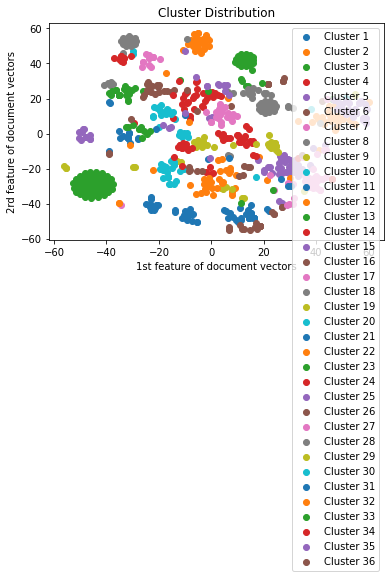

In [32]:
km_s = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=10)
labels = km_s.fit_predict(tfidf)
u_labels = np.unique(labels)
for i in u_labels:
    x = [row[0] for row in tsne_tfidf_matrix[labels == i]]
    y = [row[1] for row in tsne_tfidf_matrix[labels == i]]
    plt.scatter(x , y, label = 'Cluster ' + str(i+1))
plt.legend()
plt.xlabel("1st feature of document vectors")
plt.ylabel("2rd feature of document vectors")
plt.title('Cluster Distribution')
# plt.show()
plt.savefig('distribition.png', dpi=150)

In [33]:
from collections import Counter

In [34]:
Counter(km_s.labels_)

Counter({13: 24,
         1: 27,
         28: 12,
         16: 35,
         19: 11,
         21: 22,
         26: 23,
         17: 44,
         3: 31,
         0: 25,
         9: 25,
         25: 22,
         11: 29,
         35: 14,
         34: 15,
         31: 16,
         30: 22,
         4: 37,
         12: 34,
         22: 20,
         29: 14,
         14: 31,
         33: 13,
         10: 14,
         24: 15,
         6: 13,
         15: 21,
         18: 14,
         2: 59,
         20: 14,
         8: 19,
         7: 6,
         32: 12,
         23: 14,
         5: 9,
         27: 20})

In [35]:
df['KMeans_Cluster'] = km_s.labels_

In [36]:
paper_clusters = (df[['Title', 'KMeans_Cluster']]
                  .sort_values(by=['KMeans_Cluster'])
                 .groupby('KMeans_Cluster').head(3))

In [37]:
paper_clusters

,Title,KMeans_Cluster
106,Agent Scheduling in Opinion Dynamics: A Taxono...,0
45,Agent-Based Simulation of West Asian Urban Dyn...,0
236,Robust Clustering in Generalized Bounded Confi...,0
408,Evolving Greenhouses: An Agent-Based Model of ...,1
314,Innovation Suppression and Clique Evolution in...,1
...,...,...
591,Agent-Based Urban Land Markets: Agent's Pricin...,34
258,TreatMethHarm: An Agent-Based Simulation of Ho...,34
63,An Agent-Based Model for Simulating Inter-Sett...,35
145,"Task Structure, Individual Bounded Rationality...",35


In [38]:
feature_names = cv.get_feature_names_out()
pd.DataFrame(feature_names).T

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,agentbased,agentbased model,analysis,approach,base,data,different,dynamic,effect,individual,...,paper,process,result,show,simulation,social,study,system,theory,use


In [39]:
ordered_centroids = km_s.cluster_centers_.argsort()

In [40]:
ordered_centroids

array([[ 2, 10, 12,  3,  9,  6,  8,  5, 14, 20, 21, 15, 16, 13, 22,  4,
        18, 19, 17,  1,  0, 11,  7],
       [ 3, 14, 21,  8,  7,  6,  2,  5,  9, 12, 19, 15, 10, 16, 13,  4,
        18, 22, 17,  1, 11,  0, 20],
       [ 0, 20, 19, 18, 17, 16, 15, 14, 13, 12, 21, 11,  9,  8,  7,  6,
         5,  4,  3,  2,  1, 10, 22],
       [12, 20, 19,  2, 14,  7,  3, 10, 18,  8, 16,  6, 21, 15,  9, 13,
        17,  4,  1,  5,  0, 22, 11],
       [ 5, 13,  3, 21,  6, 16,  4,  2, 14, 20, 15,  9, 10, 19, 17, 22,
         7,  8,  1,  0, 11, 18, 12],
       [22, 18, 17, 16, 15, 14, 13, 12, 19, 10,  8,  7,  6,  5,  4,  3,
         2,  1,  9, 20, 21, 11,  0],
       [ 9, 15, 10, 21, 12,  1,  4, 16, 18,  7,  8,  5, 20, 19, 13,  6,
         3, 14, 22,  2, 11,  0, 17],
       [ 8, 14, 12, 21, 10,  9, 15, 16,  6,  5,  3, 20,  0,  1, 19, 13,
         4, 22, 11,  7, 17, 18,  2],
       [22, 15, 13, 21,  9, 16, 19,  5,  4,  3,  2,  6,  1, 12,  8,  7,
        10, 14, 11, 20,  0, 17, 18],
       [ 6,  9, 10,

In [41]:
topn_features = 10
for cluster_num in range(NUM_CLUSTERS):
    key_features = [feature_names[index]
                       for index in ordered_centroids[cluster_num, : topn_features]]
    papers = paper_clusters[paper_clusters['KMeans_Cluster'] == cluster_num]['Title'].values
    print('CLUSTER #' + str(cluster_num))
    print('Key Features:', key_features)
    print('Papers:', papers)
    print('-'*80)

CLUSTER #0
Key Features: ['analysis', 'interaction', 'network', 'approach', 'individual', 'different', 'effect', 'data', 'process', 'system']
Papers: ['Agent Scheduling in Opinion Dynamics: A Taxonomy and Comparison Using Generalized Models'
 'Agent-Based Simulation of West Asian Urban Dynamics: Impact of Refugees'
 'Robust Clustering in Generalized Bounded Confidence Models']
--------------------------------------------------------------------------------
CLUSTER #1
Key Features: ['approach', 'process', 'theory', 'effect', 'dynamic', 'different', 'analysis', 'data', 'individual', 'network']
Papers: ['Evolving Greenhouses: An Agent-Based Model of Universal Darwinism in Greenhouse Horticulture'
 'Innovation Suppression and Clique Evolution in Peer-Review-Based, Competitive Research Funding Systems: An Agent-Based Model'
 'The Interplay Between Conformity and Anticonformity and its Polarizing Effect on Society']
----------------------------------------------------------------------------

In [42]:
pd.options.display.max_colwidth = 150

In [43]:
import dataframe_image as dfi
dfi.export(paper_clusters, 'result.png')

ValueError: Your DataFrame has more than 100 rows and will produce a huge image file, possibly causing your computer to crash. Override this error by explicitly setting `max_rows`. Use -1 for all rows.